In [2]:
import os
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from numpy import linalg as LA
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from matplotlib.pyplot import *
#import sounddevice as sd
from scipy import stats

In [3]:
def segment(data, fs, start=None, duration=None):
    i=int(start*fs)
    j=int(duration*fs)
    return data[i:i+j]

In [4]:
def myspectrogram_hann(x,m,fs):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a Hanning window
    
    # Inputs: 
    #         x - data
    #         m - window size
    #         fs - sampling rate
    
    # Your code here
    lx=len(x)
    nt=(lx+m-1)//m
    xp=append(x,zeros(-lx+nt*m))

    
    # Task 2: Hanning windowing
    xm=reshape(xp,(m,nt),order='F')
    xmw=xm*outer(hanning(m),ones(nt))
    xmf=fft(xmw,len(xmw),axis=0)
    
    #f_range=[0.0, fs/4]
    #t_range=[0.0, lx/fs]
    #fig = sg_plot(t_range, f_range, xmf[0:m//4,:], dbf=60)
    
    return xmf#, fig

In [5]:
# Get directory and file names for speaker f
def get_filenames(f):
    
    poi='{0:04}'.format(f+1)
    str_poi="id1{}".format(poi)
    
    roots=[]
    fnames=[]
    dirnames=[]
    if __name__ == "__main__":
        for (root,dirs,files) in os.walk(str_poi, topdown=True):
            dirnames.append(dirs)
            fnames.append(files)
    
    return dirnames, fnames, str_poi

In [6]:
# Compute the average power for a speaker over ALL his/her test folders

def pave_over_test_dirs(dirnames,fnames,str_poi, test_dir, win_pow):
    
    #fig4= plt.plot(figsize=(16,4))
    
    P_aves=[]
    P_sigs=[]

    for d  in [x for x in range(ndirs) if x != test_dir]:   
        for j in range(0,len(fnames[d+1])):
            full_path=os.path.join(str_poi,dirnames[0][d],fnames[d+1][j])
            (fs, datam) = wavfile.read(full_path)
            xmf = myspectrogram_hann(datam,win_pow,fs)
                
            power = abs(xmf)
            P_ave = power.mean(axis=1)
            P_sig = power.var(axis=1)

            P_aves.append(P_ave)
            P_sigs.append(P_sig)
    
    Pave = np.array(P_aves).mean(axis=0)
    Psig = sqrt(np.array(P_sigs).mean(axis=0))
    
    return Pave, Psig

In [7]:
# Compute the average power over one folder

def pave_over_one_dir(dirnames, fnames, str_poi, d, win_pow):
    
    P_aves=[]
    P_sigs=[]
    #fig4= plt.plot(figsize=(16,4))
    
    for j in range(0, len(fnames[d+1])):
        full_path=os.path.join(str_poi,dirnames[0][d],fnames[d+1][j])
        (fs, datam) = wavfile.read(full_path)
        xmf = myspectrogram_hann(datam,win_pow,fs)
        
        power=abs(xmf)
        P_ave=power.mean(axis=1)
        P_sig=power.var(axis=1)
        
        P_aves.append(P_ave)
        P_sigs.append(P_sig)
    
    Pave = (np.array(P_aves).mean(axis=0))
    Psig = sqrt(np.array(P_sigs).mean(axis=0))
    
    return Pave, Psig

In [8]:
def normalize(xmf_ds, Pave, Psig):
    
    Pavem = np.outer(Pave[0:xmf_ds.shape[0]],np.ones(xmf_ds.shape[1]))
    Psigm = np.outer(Psig[0:xmf_ds.shape[0]],np.ones(xmf_ds.shape[1]))
    
    xmf_norm = abs(xmf_ds) / Pavem
    #xmf_norm = (abs(xmf_ds) - Pavem) / Psigm
    
    return xmf_norm

In [9]:
def trgm(Sb, P2, P):
    
    (length,D) = Sb.shape
    trigram=np.zeros((length-2,D))
    
    for i in range(length-2):
        trigram[i,:]=Sb[i,:][P2]*Sb[i+1,:][P]*Sb[i+2,:]
        
    return trigram

# Define Parameters

In [10]:
D=1024
n_poi=20
nlabels=40
win_pow = 80    # 64 / 16kHz = 4 ms
win_xmf = 80
step = 4        # 5 * 4ms = 20 ms

In [11]:
# Generate Random HD-Vectors
L=2*np.random.randint(2, size=(2*nlabels, D))-1
P=np.random.permutation(D)
P2=P[P]

# Identify the test folder for every speaker

In [12]:
test_dir=np.zeros(n_poi, dtype=int8)
test_nfiles=np.zeros(n_poi, dtype=int8)

for f in range(n_poi):
    
    dirnames,fnames, str_poi = get_filenames(f)
    
    ndirs=len(dirnames[0])
    nfiles=np.zeros(ndirs)
    ind_min=0
    n_min=1000

    for i in range(ndirs):
        nfiles[i]=len(fnames[i+1])
        if (len(fnames[i+1])>=5 and len(fnames[i+1])<n_min):
            n_min=len(fnames[i+1])
            ind_min=i
    #print(nfiles)
    test_dir[f]=ind_min
    test_nfiles[f]=n_min

# Training

In [13]:
profile=np.zeros([n_poi,D])
profile_dcs=[]
t_train=np.zeros(n_poi)


for f in range(n_poi):
    
    dirnames,fnames, str_poi = get_filenames(f)
    ndirs=len(dirnames[0])
    
    
    t=0
    dc=0
    profile_d=np.zeros([ndirs-1,D])
    for d in [x for x in range(ndirs) if x != test_dir[f]]:   

        #Pave, Psig = pave_over_one_dir(dirnames, fnames, str_poi, d, win_pow)
        
        
        for j in range(0, len(fnames[d+1])):
            
            full_path=os.path.join(str_poi,dirnames[0][d],fnames[d+1][j])
            (fs, datam) = wavfile.read(full_path)
            xmf = myspectrogram_hann(datam,win_xmf,fs)
            xmf_ds = xmf[:, ::step]
            
            deltat=len(datam)/fs
            t+=deltat
            #print(t)
            
            power = abs(xmf_ds)**2
            E = power.mean(axis=0)
            
            
            # HD Encoder
            P_diff = abs(xmf_ds[1:nlabels,:]) - abs(xmf_ds[0:nlabels-1,:])
            P_sign=(P_diff>=0).astype(int)
            
            S=np.zeros((P_sign.shape[1],D))

            for i in range(nlabels-1):
                S+=L[2*i+P_sign[i,:],:]
    
            Sb=((S>=0).astype(int))*2-1
            Sbw = np.multiply(Sb.T, E**0.25).T
    
            # Compute Trigrams
            trigram = trgm(Sbw, P2, P)
            
    
            #Compute Profile Vector
            profile_d[dc,:]+=sum(trigram,0)
        
        
        profile[f,:]+=profile_d[dc,:]
        profile_d[dc,:]=profile_d[dc,:]/LA.norm(profile_d[dc,:],2)
        dc+=1
    
    profile[f,:]=profile[f,:]/LA.norm(profile[f,:],2)
                                      
    #profile_dcs.append(profile_d)
    print(f,t)
    t_train[f]=t

0 548.2841875000003
1 790.3278750000001
2 969.370375
3 927.2064374999998
4 409.7633749999999
5 1092.8475
6 654.3646875000002
7 884.5263124999996
8 417.32337500000006
9 426.8028750000001
10 937.9271250000002
11 1078.3691249999997
12 282.44274999999993
13 732.3656874999998
14 455.7635
15 2339.335500000001
16 890.769125
17 1799.6565000000005
18 500.12456250000014
19 4453.196500000006


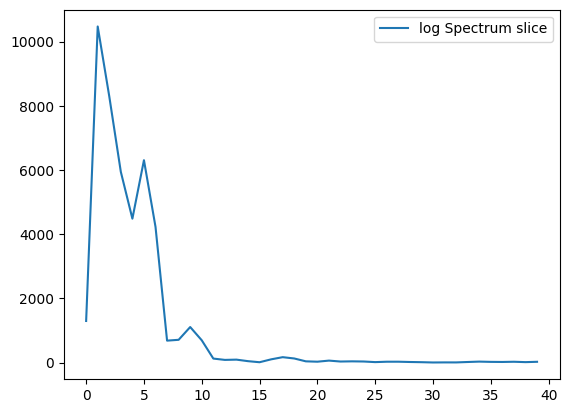

In [22]:
fig2= plt.plot()
#plt.plot((Pave[0:nlabels]),label="log Pave")
plt.plot((abs(xmf_ds[0:nlabels,100])),label="log Spectrum slice")
#plt.plot(((xmf_norm[0:nlabels,100])), label="log Normalized Spectrum Slice")
legend()

In [15]:
profile@profile.T

array([[1.        , 0.93820055, 0.95871745, 0.9763489 , 0.97960809,
        0.943766  , 0.91413167, 0.92704057, 0.97647708, 0.96279522,
        0.96444441, 0.92529047, 0.93108467, 0.9271218 , 0.91177374,
        0.97110204, 0.95401087, 0.94131836, 0.94206234, 0.9381182 ],
       [0.93820055, 1.        , 0.96118068, 0.93349277, 0.95326841,
        0.87420381, 0.85888062, 0.88013323, 0.92144276, 0.94490457,
        0.95429136, 0.94964482, 0.83769424, 0.8462222 , 0.84641339,
        0.95977848, 0.95647652, 0.96726591, 0.95663355, 0.94487346],
       [0.95871745, 0.96118068, 1.        , 0.9712199 , 0.96095079,
        0.92190447, 0.88089294, 0.92908619, 0.96746028, 0.96029331,
        0.97876787, 0.9455415 , 0.88794876, 0.89793963, 0.8999813 ,
        0.96977721, 0.97379581, 0.97475027, 0.97860125, 0.94519367],
       [0.9763489 , 0.93349277, 0.9712199 , 1.        , 0.96309886,
        0.9612943 , 0.92641163, 0.94695543, 0.97456071, 0.97052264,
        0.97683502, 0.9446698 , 0.9263724 , 0

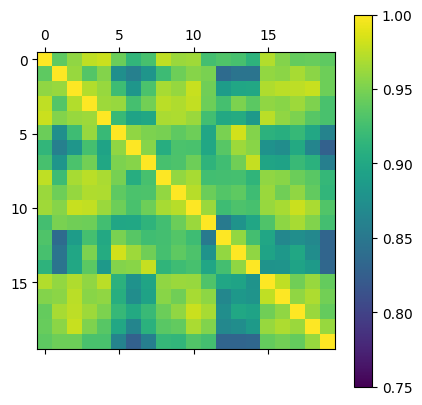

In [16]:
cc = profile @ profile.T
plt.matshow(cc)
plt.colorbar()
plt.clim(0.75,1)

# Test with Validation Set

In [17]:
profilet=np.zeros([n_poi,D])
table=np.zeros((n_poi,n_poi),dtype=int)
table5=np.zeros((n_poi,n_poi),dtype=int)
t_test=np.zeros(n_poi)

for f in range(n_poi):

    dirnames,fnames, str_poi = get_filenames(f)
    
    t=0
    #sim_itrs=[]
    
    for d in range(test_dir[f],test_dir[f]+1):
        
        
        for j in range(0, len(fnames[d+1])):
            
            full_path=os.path.join(str_poi,dirnames[0][d],fnames[d+1][j])
            (fs, datam) = wavfile.read(full_path)
            xmf = myspectrogram_hann(datam,win_xmf,fs)
            xmf_ds = xmf[:, ::step]
            
            deltat=len(datam)/fs
            t+=deltat
            #print(t)
            
            
            power = abs(xmf_ds)**2
            E = power.mean(axis=0)
            
            
            # HD Encoder
            P_diff = abs(xmf_ds[1:nlabels,:]) - abs(xmf_ds[0:nlabels-1,:])
            P_sign=(P_diff>=0).astype(int)
            
            S=np.zeros((P_sign.shape[1],D))

            for i in range(nlabels-1):
                S+=L[2*i+P_sign[i,:],:]
    
            Sb=((S>=0).astype(int))*2-1
            Sbw = np.multiply(Sb.T, E**0.25).T
    
            # Compute Trigrams
            trigram = trgm(Sbw, P2, P)

            #Compute Profile Vector
            profilet[f,:]+=sum(trigram,0)

    print(f,t)
    t_test[f]=t
    
    
    profilet[f,:]=profilet[f,:]/LA.norm(profilet[f,:],2)
    similarity=profilet[f,:]@profile.T
    #print(similarity)
    #sim_itrs=np.array(sim_itrs)
               
    max_index=np.argmax(similarity)
    #for k in range(sim_itrs.shape[0]):
    table[f,max_index]+=1
    
    top5_indices = (-similarity).argsort()[:5]
    table5[f,top5_indices]+=1
    

0 101.480625
1 25.6403125
2 24.840312500000003
3 42.3203125
4 37.4403125
5 52.160374999999995
6 39.120375
7 65.2403125
8 26.560312500000002
9 37.640375
10 45.4003125
11 28.3203125
12 28.480312499999997
13 39.3603125
14 44.08031249999999
15 53.7203125
16 37.600375
17 28.8403125
18 34.3603125
19 56.64031249999999


In [18]:
accuracy=np.zeros(n_poi)
for q in range(n_poi):
    accuracy[q]=table[q,q]/sum(table[q,:])
    
print('Top-1: ', mean(accuracy))

Top-1:  0.9


In [19]:
c=0
for q in range(n_poi):
    if table5[q,q]==1:
        c+=1
accuracy_top5=c/n_poi

print('Top-5: ', accuracy_top5)

Top-5:  1.0
